RESNET50 (LATEST) + VISION TRANSFORMER ENSEMBLE
WITH MIXTURE OF DATA AUGMENTATION

[STAGE 1] Loading and Preprocessing Data...
✓ Total samples: 27558
✓ Train: 19290 (70%)
✓ Val: 5511 (20%)
✓ Test: 2757 (10%)

[AUGMENTATION] Setting up Mixture of Augmentation Strategies...
✓ Applying mixture augmentation to training data...

[STAGE 2A] Building Feature Extractors...
⏱ Stage 1 Time: 0.65 seconds

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✓ ResNet50 Extractor: 24,636,800 parameters
✓ ViT Extractor: 1,383,168 parameters

[STAGE 2B] Partially Fine-tuning Models with Augmented Data...

✓ Fine-tuning ResNet50_Extractor...
  Trainable params in ResNet50_Extractor: 0
Epoch 1/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 133s 181ms/step - accuracy: 0.5112 - loss: 0.7354 - val_accuracy: 0.4983 - val_loss: 0.6931
Epoch 2/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 93s 155ms/step - accuracy: 0.5051 - loss: 0.6931 - val_accuracy: 0.4970 - val_loss: 0.6931
Epoch 3/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 143s 156ms/step - acc

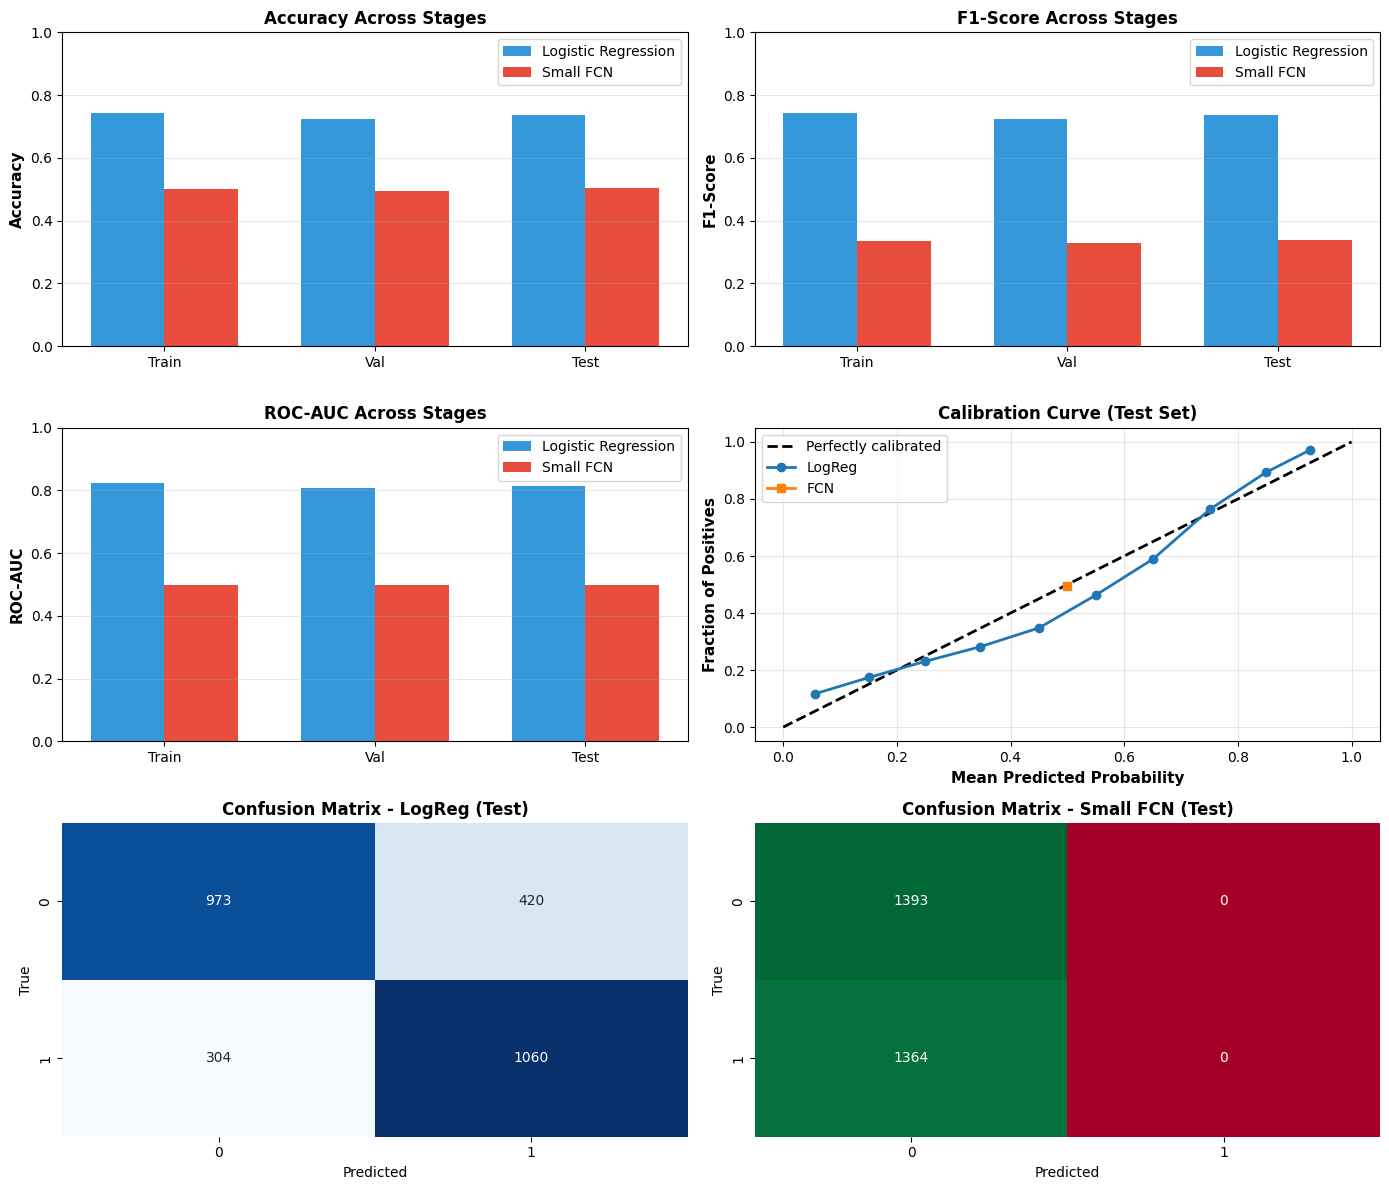

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, Model
import warnings
import time

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 70)
print("RESNET50 (LATEST) + VISION TRANSFORMER ENSEMBLE")
print("WITH MIXTURE OF DATA AUGMENTATION")
print("=" * 70)

# ============================================================================
# STAGE 1: LOAD AND PREPROCESS DATA (70/20/10 split)
# ============================================================================
print("\n[STAGE 1] Loading and Preprocessing Data...")
stage1_start = time.time()

def load_malaria_data():
    """Load malaria dataset with 70/20/10 split"""
    (train_data, info) = tfds.load(
        'malaria',
        split='train',
        with_info=True,
        as_supervised=True
    )

    total_samples = info.splits['train'].num_examples
    train_size = int(0.7 * total_samples)
    val_size = int(0.2 * total_samples)

    train_data = train_data.take(train_size)
    val_test_data = tfds.load('malaria', split='train', as_supervised=True).skip(train_size)
    val_data = val_test_data.take(val_size)
    test_data = val_test_data.skip(val_size)

    return train_data, val_data, test_data, total_samples

def preprocess_image(image, label, target_size=224):
    """Preprocess image for both ResNet50 and ViT"""
    image = tf.image.resize(image, (target_size, target_size))
    image = image / 255.0
    return image, label

# Load data
train_data, val_data, test_data, total_samples = load_malaria_data()

train_size = int(0.7 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

print(f"✓ Total samples: {total_samples}")
print(f"✓ Train: {train_size} (70%)")
print(f"✓ Val: {val_size} (20%)")
print(f"✓ Test: {test_size} (10%)")

# ============================================================================
# MIXTURE OF DATA AUGMENTATION STRATEGIES
# ============================================================================
print("\n[AUGMENTATION] Setting up Mixture of Augmentation Strategies...")

class MixtureAugmentation(layers.Layer):
    """Mixture of augmentation techniques applied stochastically"""
    def __init__(self, **kwargs):
        super(MixtureAugmentation, self).__init__(**kwargs)

    def call(self, x, training=None):
        if not training:
            return x

        # Random selection of augmentation strategy (0-4)
        aug_choice = tf.random.uniform([], 0, 5, dtype=tf.int32)

        # Strategy 1: Random Rotation + Zoom
        def strategy_1(img):
            img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
            scale = tf.random.uniform([], 1.0, 1.2)
            new_size = tf.cast(224.0 * scale, tf.int32)
            img = tf.image.resize(img, (new_size, new_size))
            img = tf.image.resize(img, (224, 224))
            return img

        # Strategy 2: Brightness + Contrast + Saturation
        def strategy_2(img):
            img = tf.image.adjust_brightness(img, 0.1 * tf.random.uniform([], -1.0, 1.0))
            img = tf.image.adjust_contrast(img, 1.0 + 0.15 * tf.random.uniform([], -1.0, 1.0))
            img = tf.image.adjust_saturation(img, 1.0 + 0.2 * tf.random.uniform([], -1.0, 1.0))
            return img

        # Strategy 3: Random Horizontal/Vertical Flip
        def strategy_3(img):
            img = tf.cond(
                tf.random.uniform([], 0, 1) > 0.5,
                lambda: tf.image.flip_left_right(img),
                lambda: img
            )
            img = tf.cond(
                tf.random.uniform([], 0, 1) > 0.5,
                lambda: tf.image.flip_up_down(img),
                lambda: img
            )
            return img

        # Strategy 4: Gaussian Noise
        def strategy_4(img):
            noise = tf.random.normal(tf.shape(img), stddev=0.05)
            img = tf.clip_by_value(img + noise, 0.0, 1.0)
            return img

        # Strategy 5: Random Cropping + Padding
        def strategy_5(img):
            scale = tf.random.uniform([], 0.85, 1.0)
            crop_size = tf.cast(224.0 * scale, tf.int32)
            img = tf.image.random_crop(img, [crop_size, crop_size, 3])
            pad_size = (224 - crop_size) // 2
            img = tf.image.pad_to_bounding_box(img, pad_size, pad_size, 224, 224)
            return img

        # Apply selected strategy using tf.switch_case for graph compatibility
        x = tf.switch_case(
            aug_choice,
            branch_fns={
                0: lambda: strategy_1(x),
                1: lambda: strategy_2(x),
                2: lambda: strategy_3(x),
                3: lambda: strategy_4(x),
                4: lambda: strategy_5(x),
            }
        )

        return x

# Create augmentation layer
augmentation = MixtureAugmentation()

def augment_and_preprocess(image, label, target_size=224):
    """Apply augmentation + preprocessing"""
    image = tf.image.resize(image, (target_size, target_size))
    image = image / 255.0
    image = augmentation(image, training=True)
    return image, label

def preprocess_only(image, label, target_size=224):
    """Only preprocessing (for val/test)"""
    image = tf.image.resize(image, (target_size, target_size))
    image = image / 255.0
    return image, label

# Preprocess datasets with augmentation for training
batch_size = 32
print("✓ Applying mixture augmentation to training data...")
train_ds = train_data.map(augment_and_preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_data.map(preprocess_only).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_data.map(preprocess_only).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ============================================================================
# STAGE 2A: BUILD MODELS WITH FEATURE EXTRACTORS
# ============================================================================
print("\n[STAGE 2A] Building Feature Extractors...")
stage1_end = time.time()
print(f"⏱ Stage 1 Time: {stage1_end - stage1_start:.2f} seconds\n")
stage2a_start = time.time()

# Custom layer for patch extraction
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size=16, **kwargs):
        super(PatchExtractor, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        patches = tf.image.extract_patches(
            x,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        num_patches = tf.shape(patches)[1] * tf.shape(patches)[2]
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, [-1, num_patches, patch_dim])
        return patches

# ResNet50 (Latest) Feature Extractor with partial fine-tuning
def create_resnet50_extractor(input_shape=(224, 224, 3)):
    """ResNet50 with frozen backbone, partially fine-tunable top layers"""
    base_model = tf.keras.applications.ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze most layers, unfreeze last residual block for partial fine-tuning
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    model = Model(inputs=inputs, outputs=x, name='ResNet50_Extractor')
    return model

# Vision Transformer Feature Extractor with partial fine-tuning
def create_vit_extractor(input_shape=(224, 224, 3)):
    """Vision Transformer with partial fine-tuning"""
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    patch_size = 16
    x = PatchExtractor(patch_size=patch_size)(inputs)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.LayerNormalization()(x)

    # Transformer blocks (2 blocks for efficiency)
    transformer_blocks = []
    for i in range(2):
        # Multi-head attention
        attn = layers.MultiHeadAttention(
            num_heads=4, key_dim=64, dropout=0.1, name=f'vit_mha_{i}'
        )(x, x)
        x = layers.Add()([x, attn])
        x = layers.LayerNormalization()(x)

        # FFN
        ffn = layers.Dense(512, activation='relu', name=f'vit_ffn1_{i}')(x)
        ffn = layers.Dense(256, name=f'vit_ffn2_{i}')(ffn)
        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    model = Model(inputs=inputs, outputs=x, name='ViT_Extractor')
    return model

resnet_extractor = create_resnet50_extractor()
vit_extractor = create_vit_extractor()

print(f"✓ ResNet50 Extractor: {resnet_extractor.count_params():,} parameters")
print(f"✓ ViT Extractor: {vit_extractor.count_params():,} parameters")

# ============================================================================
# STAGE 2B: PARTIALLY FINE-TUNE MODELS WITH AUGMENTATION
# ============================================================================
print("\n[STAGE 2B] Partially Fine-tuning Models with Augmented Data...")

def fine_tune_extractors(train_ds, val_ds, epochs=15):
    """Partially fine-tune feature extractors using classification objective"""
    for extractor in [resnet_extractor, vit_extractor]:
        # Create temporary model with classification head for fine-tuning only
        temp_input = layers.Input(shape=(224, 224, 3))
        features = extractor(temp_input)
        logits = layers.Dense(2, name='temp_classification_head')(features)
        temp_model = Model(inputs=temp_input, outputs=logits)

        temp_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        print(f"\n✓ Fine-tuning {extractor.name}...")
        print(f"  Trainable params in {extractor.name}: ", end="")
        trainable_count = sum([tf.size(w).numpy() for w in temp_model.trainable_weights if 'resnet50' in w.name.lower() or 'vit' in w.name.lower()])
        print(f"{trainable_count:,}")

        history = temp_model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=1
        )
        print(f"  Final train loss: {history.history['loss'][-1]:.4f}, "
              f"val loss: {history.history['val_loss'][-1]:.4f}")

fine_tune_extractors(train_ds, val_ds, epochs=15)
stage2b_end = time.time()

# ============================================================================
# STAGE 2C: EXTRACT FEATURES (without classification head)
# ============================================================================
print("\n[STAGE 2C] Extracting Features from Fine-tuned Models...")
stage2c_start = time.time()

def extract_features(model, dataset):
    """Extract features from dataset using fine-tuned extractor"""
    features_list, labels_list = [], []
    for images, labels in dataset:
        features = model(images, training=False)
        features_list.append(features.numpy())
        labels_list.append(labels.numpy())
    return np.concatenate(features_list), np.concatenate(labels_list)

print("✓ Extracting ResNet50 features...")
train_resnet, train_labels = extract_features(resnet_extractor, train_ds)
val_resnet, val_labels = extract_features(resnet_extractor, val_ds)
test_resnet, test_labels = extract_features(resnet_extractor, test_ds)

print("✓ Extracting ViT features...")
train_vit, _ = extract_features(vit_extractor, train_ds)
val_vit, _ = extract_features(vit_extractor, val_ds)
test_vit, _ = extract_features(vit_extractor, test_ds)

print(f"✓ ResNet50 feature shape: {train_resnet.shape}")
print(f"✓ ViT feature shape: {train_vit.shape}")

stage2c_end = time.time()
print(f"⏱ Stage 2C Time: {stage2c_end - stage2c_start:.2f} seconds")

# ============================================================================
# STAGE 3: FUSE EMBEDDINGS
# ============================================================================
print("\n[STAGE 3] Fusing Embeddings...")
stage3_start = time.time()

# Concatenate embeddings from both models
train_embeddings = np.concatenate([train_resnet, train_vit], axis=1)
val_embeddings = np.concatenate([val_resnet, val_vit], axis=1)
test_embeddings = np.concatenate([test_resnet, test_vit], axis=1)

print(f"✓ Fused embedding shape: {train_embeddings.shape}")

# Fusion Method 1: Logistic Regression
print("\n[FUSION 1] Training Logistic Regression...")
lr_start = time.time()
fusion_lr = LogisticRegression(max_iter=1000, random_state=42, verbose=0)
fusion_lr.fit(train_embeddings, train_labels)
lr_end = time.time()
print(f"✓ Logistic Regression fusion completed")
print(f"  ⏱ LogReg Training Time: {lr_end - lr_start:.2f} seconds")

# Fusion Method 2: Small FCN
print("\n[FUSION 2] Training Small FCN...")
fcn_model = tf.keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(1024,)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

fcn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

fcn_start = time.time()
history_fcn = fcn_model.fit(
    train_embeddings, train_labels,
    validation_data=(val_embeddings, val_labels),
    epochs=30,
    batch_size=32,
    verbose=1
)
fcn_end = time.time()
print(f"✓ Small FCN fusion completed - Final val accuracy: {history_fcn.history['val_accuracy'][-1]:.4f}")
print(f"  ⏱ FCN Training Time: {fcn_end - fcn_start:.2f} seconds")

stage3_end = time.time()
print(f"\n⏱ Stage 3 Total Time: {stage3_end - stage3_start:.2f} seconds")

# ============================================================================
# STAGE 4: EVALUATE MODELS
# ============================================================================
print("\n[STAGE 4] Evaluation Metrics...")
stage4_start = time.time()

def evaluate_fusion(embeddings, labels, fusion_model, method_name):
    """Comprehensive evaluation with accuracy, F1-score, and calibration"""

    if isinstance(fusion_model, LogisticRegression):
        predictions = fusion_model.predict(embeddings)
        probabilities = fusion_model.predict_proba(embeddings)
    else:  # FCN model
        probabilities = fusion_model.predict(embeddings, verbose=0)
        predictions = np.argmax(probabilities, axis=1)

    # Metrics
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    auc = roc_auc_score(labels, probabilities[:, 1])

    # Calibration curve
    frac_pos, mean_pred = calibration_curve(labels, probabilities[:, 1], n_bins=10)

    # Confusion matrix
    cm = confusion_matrix(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'auc': auc,
        'calibration': (frac_pos, mean_pred),
        'confusion_matrix': cm,
        'predictions': predictions,
        'probabilities': probabilities
    }

print("\n" + "="*70)
print("LOGISTIC REGRESSION FUSION RESULTS")
print("="*70)
train_metrics_lr = evaluate_fusion(train_embeddings, train_labels, fusion_lr, "LogReg")
val_metrics_lr = evaluate_fusion(val_embeddings, val_labels, fusion_lr, "LogReg")
test_metrics_lr = evaluate_fusion(test_embeddings, test_labels, fusion_lr, "LogReg")

print(f"\nTraining Set:")
print(f"  ✓ Accuracy: {train_metrics_lr['accuracy']:.4f}")
print(f"  ✓ F1-Score: {train_metrics_lr['f1']:.4f}")
print(f"  ✓ ROC-AUC: {train_metrics_lr['auc']:.4f}")

print(f"\nValidation Set:")
print(f"  ✓ Accuracy: {val_metrics_lr['accuracy']:.4f}")
print(f"  ✓ F1-Score: {val_metrics_lr['f1']:.4f}")
print(f"  ✓ ROC-AUC: {val_metrics_lr['auc']:.4f}")

print(f"\nTest Set:")
print(f"  ✓ Accuracy: {test_metrics_lr['accuracy']:.4f}")
print(f"  ✓ F1-Score: {test_metrics_lr['f1']:.4f}")
print(f"  ✓ ROC-AUC: {test_metrics_lr['auc']:.4f}")

print("\n" + "="*70)
print("SMALL FCN FUSION RESULTS")
print("="*70)
train_metrics_fcn = evaluate_fusion(train_embeddings, train_labels, fcn_model, "FCN")
val_metrics_fcn = evaluate_fusion(val_embeddings, val_labels, fcn_model, "FCN")
test_metrics_fcn = evaluate_fusion(test_embeddings, test_labels, fcn_model, "FCN")

print(f"\nTraining Set:")
print(f"  ✓ Accuracy: {train_metrics_fcn['accuracy']:.4f}")
print(f"  ✓ F1-Score: {train_metrics_fcn['f1']:.4f}")
print(f"  ✓ ROC-AUC: {train_metrics_fcn['auc']:.4f}")

print(f"\nValidation Set:")
print(f"  ✓ Accuracy: {val_metrics_fcn['accuracy']:.4f}")
print(f"  ✓ F1-Score: {val_metrics_fcn['f1']:.4f}")
print(f"  ✓ ROC-AUC: {val_metrics_fcn['auc']:.4f}")

print(f"\nTest Set:")
print(f"  ✓ Accuracy: {test_metrics_fcn['accuracy']:.4f}")
print(f"  ✓ F1-Score: {test_metrics_fcn['f1']:.4f}")
print(f"  ✓ ROC-AUC: {test_metrics_fcn['auc']:.4f}")

stage4_end = time.time()
print(f"\n⏱ Stage 4 Time: {stage4_end - stage4_start:.2f} seconds")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\nGenerating visualizations...")
viz_start = time.time()

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Accuracy comparison
stages = ['Train', 'Val', 'Test']
acc_lr = [train_metrics_lr['accuracy'], val_metrics_lr['accuracy'], test_metrics_lr['accuracy']]
acc_fcn = [train_metrics_fcn['accuracy'], val_metrics_fcn['accuracy'], test_metrics_fcn['accuracy']]

x = np.arange(len(stages))
width = 0.35
axes[0, 0].bar(x - width/2, acc_lr, width, label='Logistic Regression', color='#3498db')
axes[0, 0].bar(x + width/2, acc_fcn, width, label='Small FCN', color='#e74c3c')
axes[0, 0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Accuracy Across Stages', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(stages)
axes[0, 0].set_ylim([0, 1])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# F1-Score comparison
f1_lr = [train_metrics_lr['f1'], val_metrics_lr['f1'], test_metrics_lr['f1']]
f1_fcn = [train_metrics_fcn['f1'], val_metrics_fcn['f1'], test_metrics_fcn['f1']]

axes[0, 1].bar(x - width/2, f1_lr, width, label='Logistic Regression', color='#3498db')
axes[0, 1].bar(x + width/2, f1_fcn, width, label='Small FCN', color='#e74c3c')
axes[0, 1].set_ylabel('F1-Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('F1-Score Across Stages', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(stages)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# ROC-AUC comparison
auc_lr = [train_metrics_lr['auc'], val_metrics_lr['auc'], test_metrics_lr['auc']]
auc_fcn = [train_metrics_fcn['auc'], val_metrics_fcn['auc'], test_metrics_fcn['auc']]

axes[1, 0].bar(x - width/2, auc_lr, width, label='Logistic Regression', color='#3498db')
axes[1, 0].bar(x + width/2, auc_fcn, width, label='Small FCN', color='#e74c3c')
axes[1, 0].set_ylabel('ROC-AUC', fontsize=11, fontweight='bold')
axes[1, 0].set_title('ROC-AUC Across Stages', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(stages)
axes[1, 0].set_ylim([0, 1])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Calibration curves (Test set)
frac_pos_lr, mean_pred_lr = test_metrics_lr['calibration']
frac_pos_fcn, mean_pred_fcn = test_metrics_fcn['calibration']

axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=2)
axes[1, 1].plot(mean_pred_lr, frac_pos_lr, 'o-', label='LogReg', linewidth=2, markersize=6)
axes[1, 1].plot(mean_pred_fcn, frac_pos_fcn, 's-', label='FCN', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Mean Predicted Probability', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Fraction of Positives', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Calibration Curve (Test Set)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Confusion matrices (Test set)
cm_lr = test_metrics_lr['confusion_matrix']
cm_fcn = test_metrics_fcn['confusion_matrix']

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[2, 0], cbar=False)
axes[2, 0].set_title('Confusion Matrix - LogReg (Test)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Predicted')
axes[2, 0].set_ylabel('True')

sns.heatmap(cm_fcn, annot=True, fmt='d', cmap='RdYlGn', ax=axes[2, 1], cbar=False)
axes[2, 1].set_title('Confusion Matrix - Small FCN (Test)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Predicted')
axes[2, 1].set_ylabel('True')

plt.tight_layout()
plt.savefig('ensemble_evaluation.png', dpi=150, bbox_inches='tight')
print("✓ Visualization saved as 'ensemble_evaluation.png'")

viz_end = time.time()
print(f"⏱ Visualization Time: {viz_end - viz_start:.2f} seconds")

print("\n" + "=" * 70)
print("ENSEMBLE TRAINING AND EVALUATION COMPLETED!")
print("=" * 70)

# Total timing summary
total_time = viz_end - stage1_start

print("\n" + "=" * 70)
print("⏱ TIMING SUMMARY")
print("=" * 70)
print(f"\nStage 1 (Data Loading & Preprocessing): {stage1_end - stage1_start:.2f} seconds")
print(f"Stage 2A-2B (Build & Fine-tune Models): {stage2b_end - stage2a_start:.2f} seconds")
print(f"Stage 2C (Feature Extraction): {stage2c_end - stage2c_start:.2f} seconds")
print(f"Stage 3 (Embedding Fusion): {stage3_end - stage3_start:.2f} seconds")
print(f"Stage 4 (Evaluation): {stage4_end - stage4_start:.2f} seconds")
print(f"Visualization: {viz_end - viz_start:.2f} seconds")

print(f"\n{'='*70}")
print(f"TOTAL PIPELINE TIME: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
print(f"{'='*70}")